load required libraries

In [8]:
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import math

load the original image, downsample it, and transform it to grayscale

In [9]:
orig_image = Image.open('NoiseFreeExample.png')
orig_image = orig_image.resize((128,128))
orig_image = np.array(orig_image)
grayscale_transform = np.array([0.299, 0.587, 0.114])
orig_image = np.dot(orig_image[...,:3], grayscale_transform)

add noise to the original image

In [10]:
def add_noise_to_image(orig_image, covar=10):
    noisy_image = np.random.normal(orig_image, math.sqrt(covar) * np.ones(orig_image.shape))
    noisy_image[noisy_image < 0] = 0
    noisy_image[noisy_image > 255] = 255
    return noisy_image

noisy_image = add_noise_to_image(orig_image, 200)

Plot and save the downsized image with added noise.

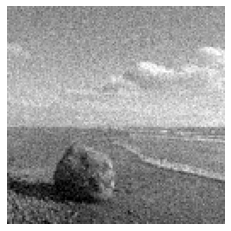

In [11]:
plt.imshow(noisy_image, cmap=plt.get_cmap("gray"))
plt.axis("off")
plt.savefig("noisy_image.png")
plt.show()

Plot and save the downsized original image.

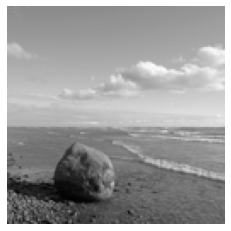

In [12]:
plt.imshow(orig_image, cmap=plt.get_cmap("gray"))
plt.axis("off")
plt.savefig("true_image.png")
plt.show()

Define the optimization process. More optimized variants exist and this is only for demonstration purposes.

In [13]:
from tqdm.notebook import trange

def restore_image(source_image, covar, max_diff=200, weight_diff=0.02, iterations=10):
    # Maintain two buffer images.
    # In alternate iterations, one will be the
    # source image, the other the destination.
    buffer = np.zeros((source_image.shape[0], source_image.shape[1], 2))
    buffer[:, :, 0] = source_image
    s = 1
    d = 0

    # This value is guaranteed to be larger than the
    # potential of any configuration of pixel values.
    V_max = (source_image.shape[0] * source_image.shape[1]) * ((256)**2 / (2*covar) + 4 * weight_diff * max_diff)

    for i in range(iterations):
        # Switch source and destination buffers.
        if s == 0:
            s = 1
            d = 0
        else:
            s = 0
            d = 1

        # Vary each pixel individually to find the
        # values that minimise the local potentials.
        for r in trange(source_image.shape[0]):
            for c in range(source_image.shape[1]):
                V_local = V_max
                min_val = -1
                for val in range(255):

                    # The factor for the noisy observation and the expected true image.
                    V_data = (val - source_image[r,c]**2) / (2 * covar)

                    # The factors for neighboring pixel values.
                    V_diff = 0
                    if r > 0:
                        V_diff = V_diff + min( (val - buffer[r-1,c,s])**2, max_diff )

                    if r < source_image.shape[0]-1:
                        V_diff = V_diff + min( (val - buffer[r+1,c,s])**2, max_diff )

                    if c > 0:
                        V_diff = V_diff + min( (val - buffer[r,c-1,s])**2, max_diff )

                    if c < source_image.shape[1]-1:
                        V_diff = V_diff + min( (val - buffer[r,c+1,s])**2, max_diff )

                    V_current = V_data + weight_diff * V_diff

                    if V_current < V_local:
                        min_val = val
                        V_local = V_current


                buffer[r,c,d] = min_val
    dst = buffer[:,:,d]
    return dst

Run the optimization process for multiple iterations and store all images.

In [14]:
images = []
tmp = np.copy(noisy_image)
for i in range(20):
    tmp = restore_image(tmp, 100, iterations=1)
    images.append(np.copy(tmp))

  0%|          | 0/128 [00:00<?, ?it/s]

  0%|          | 0/128 [00:00<?, ?it/s]

  0%|          | 0/128 [00:00<?, ?it/s]

  0%|          | 0/128 [00:00<?, ?it/s]

  0%|          | 0/128 [00:00<?, ?it/s]

  0%|          | 0/128 [00:00<?, ?it/s]

  0%|          | 0/128 [00:00<?, ?it/s]

  0%|          | 0/128 [00:00<?, ?it/s]

  0%|          | 0/128 [00:00<?, ?it/s]

  0%|          | 0/128 [00:00<?, ?it/s]

  0%|          | 0/128 [00:00<?, ?it/s]

  0%|          | 0/128 [00:00<?, ?it/s]

  0%|          | 0/128 [00:00<?, ?it/s]

  0%|          | 0/128 [00:00<?, ?it/s]

  0%|          | 0/128 [00:00<?, ?it/s]

  0%|          | 0/128 [00:00<?, ?it/s]

  0%|          | 0/128 [00:00<?, ?it/s]

  0%|          | 0/128 [00:00<?, ?it/s]

  0%|          | 0/128 [00:00<?, ?it/s]

  0%|          | 0/128 [00:00<?, ?it/s]

Plot the resulting images of the optimization process.

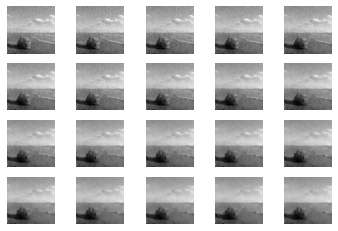

In [15]:
fig, axes = plt.subplots(4, 5)
for img, ax in zip(images, axes.flatten()):
    ax.imshow(img, cmap=plt.get_cmap("gray"))
    ax.axis("off")
plt.savefig("Iterations.pdf")
plt.show()

